In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [71]:
import scipy.fftpack

def smooth_data(data, window):
    return np.convolve(y, np.ones(window)/window, mode='same')

In [72]:
# Importing and cleaning data
df = pd.read_csv("short_term_rates.csv")
df1 = df.iloc[:, [0, 4]]
df1 = df1.iloc[5:, :]
df1["Series Description"] = pd.to_datetime(df1["Series Description"])
df1.iloc[:, 1] = pd.to_numeric(df1.iloc[:, 1], errors="coerce")
df1 = df1.dropna()
df1.iloc[:, 1] = df1.iloc[:, 1].astype('float64')

In [73]:
# Selecting random data points
import random
random.seed(90)
size = 500
padding = 50
start = random.randint(9000, 15756 - size - 2 * padding)
end = start + size + 2 * padding
x = df1.iloc[:, 0].values
y = df1.iloc[:, 1].values

x = x[start: end]
y = y[start:end]

(array([12692., 12784., 12874., 12965., 13057., 13149., 13239., 13330.,
        13422., 13514., 13604.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

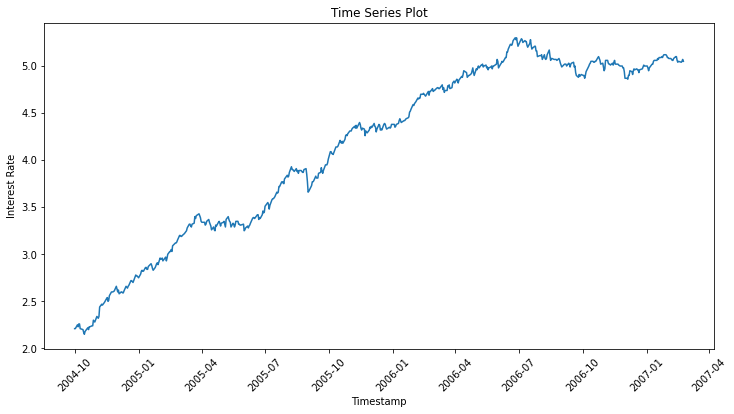

In [74]:
plt.figure(figsize=(12, 6))
plt.plot(x, y, label="Time Series Data")
plt.xlabel("Timestamp")
plt.ylabel("Interest Rate")
plt.title("Time Series Plot")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

In [75]:
# Smooting random data points
smooth_y = smooth_data(y,padding)
smooth_y = smooth_y[padding:-1 * padding]
x = x[padding:-1 * padding]
y = y[padding:-1 * padding]

(array([12784., 12874., 12965., 13057., 13149., 13239., 13330., 13422.,
        13514.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

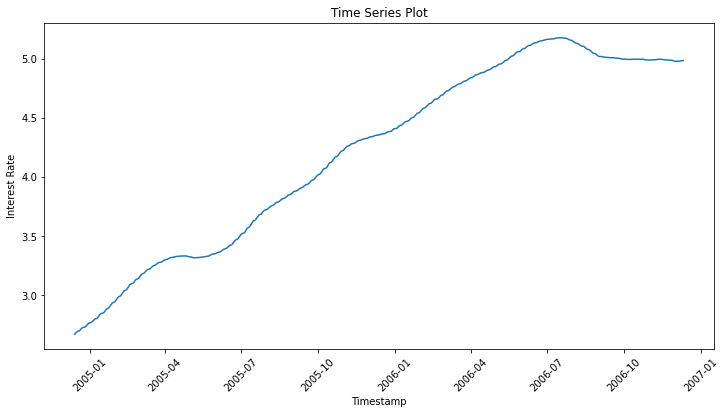

In [76]:
plt.figure(figsize=(12, 6))
plt.plot(x, smooth_y, label="Time Series Data")
plt.xlabel("Timestamp")
plt.ylabel("Interest Rate")
plt.title("Time Series Plot")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

In [77]:
def time_diff(x1, x2):
    diff = x2 - x1
    diff = diff / np.timedelta64(1, 'D')
    return diff

total_days_diff = time_diff(x[0], x[len(x) - 1])
dt = 1 / total_days_diff
deltaT = (np.diff(x) / np.timedelta64(1, 'D')) * dt
deltaR = np.diff(smooth_y)
R = smooth_y[: -1]
Rdt = R * deltaT

In [78]:
# Find a, b without sigma and dW
A = np.column_stack([deltaT, Rdt])
AT = A.T

AT_A = AT @ A
AT_A = AT_A.astype(float)
inverse_AT_A = np.linalg.inv(AT_A)
p = (inverse_AT_A @ AT)
parameters = p @ deltaR
parameters

array([ 6.29160707, -1.08199538])

In [79]:
a = -parameters[1]  
b = parameters[0] / a

# Results

The following code above provides us values for the speed of mean reversion and the long-term mean level. According to the Least squares regression, the first parameter is the long-term mean level mulitplied by speed of mean reversion while the second parameter is just the value of speed of mean reversion. 

Now we are going to test compare the model parameters to the actual data.

In [122]:
def V_Model(sigma=0.1, a=0.1, b=0.041, R_initial=0.04, dt=0.001, total_time=1):
    R = [R_initial]
    W = [0]
    t_inc = int(total_time / dt)
    T = [dt*i for i in range(t_inc)]

    for i in range(t_inc - 1):
        dW = np.random.normal()*np.sqrt(dt)
        W.append(W[i] + dW)
        dR = a * (b - R[i])*dt + sigma*dW
        R.append(R[i] + dR)
        
    return R, W, T

R1, _, T = V_Model(sigma=0.6, a=a, b=b, R_initial=R[0], dt= 1/(size), total_time=1)

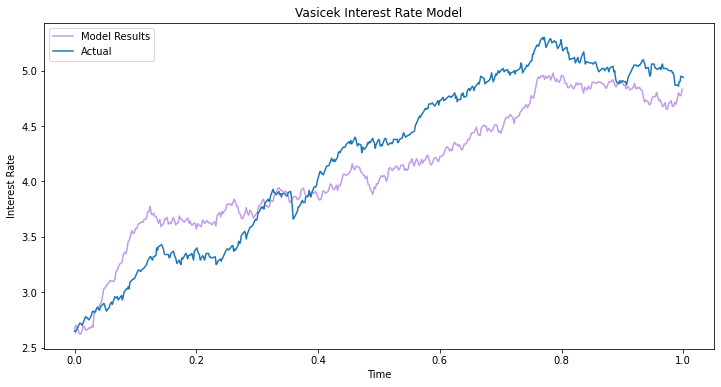

In [123]:
# Attempts to normalize actual graph
timestamps = x.astype('int64')

# Min-max normalization
min_ts, max_ts = timestamps.min(), timestamps.max()
normalized = (timestamps - min_ts) / (max_ts - min_ts)
plt.figure(figsize=(12, 6))
plt.plot(T, R1, label="Model Results", color='#c19ce9')
plt.plot(normalized, y, label="Actual")
plt.xlabel("Time")
plt.ylabel("Interest Rate")
plt.title(label="Vasicek Interest Rate Model")
plt.legend()
plt.show()

In [61]:
from sklearn.metrics import mean_squared_error

In [62]:
mean_squared_error(R1, y)

0.8409430429476249

# Results Part 2

The final result closely follows the trends displayed in the actual data. This means our parameter for a, b are relatively correct. Additionally, the mean_squared error is relatively low which means our overall correlation between the model and actual data is quite high. However, we now face the issue of how do we measure the sigma parameter of the model. 

The idea that I have for this is taking the smooth data for the interest rates and subtracting it from actual data. Then, we can take the absolute value of all the different values and take the average. Ideally, this gives us the volitility but there is no guarantee that this method is successful. 

In [90]:
diffy = y - smooth_y


In [115]:
abssum = np.sum(np.abs(diffy)) / size
abssum

0.045471599999999966

In [118]:
sigma = abssum / np.sqrt(dt)
sigma
# Accounting for the fact that dW is a normal distribution that varies with sqrt(dt)

1.2260479099811386

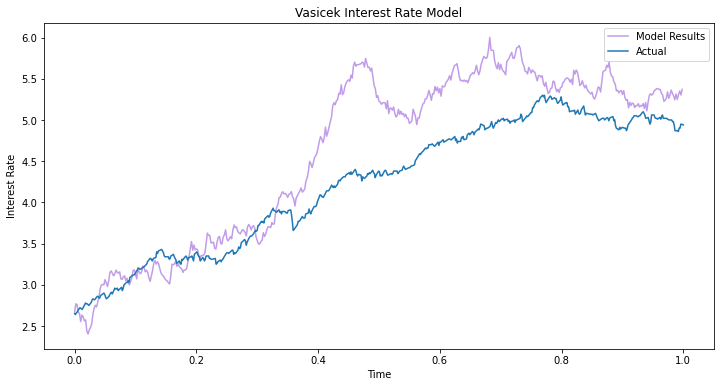

In [142]:
plt.figure(figsize=(12, 6))
R2, _, T = V_Model(sigma=sigma, a=a, b=b, R_initial=R[0], dt= 1/(size), total_time=1)
plt.plot(T, R2, label="Model Results", color='#c19ce9')
plt.plot(normalized, y, label="Actual")
plt.xlabel("Time")
plt.ylabel("Interest Rate")
plt.title(label="Vasicek Interest Rate Model")
plt.legend()
plt.show()

In [143]:
mean_squared_error(R2, y)

0.29538431591945663

In [64]:
# Finding a, b, Sigma By performing mulitple regressions
def find_absigma(trials):
    param_matrix = []
    for i in range(trials):
        dW = np.random.normal(0, 1, size - 1)
        A = np.column_stack([deltaT, Rdt, dW])
        AT = A.T
        AT_A = AT @ A
        AT_A = AT_A.astype(float)
        inverse_AT_A = np.linalg.inv(AT_A)
        p = (inverse_AT_A @ AT)
        parameters = p @ deltaR
        param_matrix.append(parameters)
    return np.sum(param_matrix, axis=0)/trials


In [65]:
total_days_diff = time_diff(x[0], x[len(x) - 1])
dt = 1 / total_days_diff
deltaT = (np.diff(x) / np.timedelta64(1, 'D')) * dt
deltaR = np.diff(y)
R = y[: -1]
Rdt = R * deltaT

params = find_absigma(100)
params

array([ 1.09429327e+01, -1.51811787e+00,  2.14698805e-04])